## By Harshil Shah (202311056)

# Training an Autoencoder with FishLeg

**FishLeg** is a `second-order optimizer` for training neural networks. This means FishLeg uses second-order information - or the curvature of weight-space - to make more optimal adjustments to weights during neural network training. This allows FishLeg to reach lower losses with fewer epochs. This notebook demonstrates using FishLeg to train a **basic autoencoder**, working with the **MNIST** dataset of handwritten digits, and compares the training performance with **Adam**, a popular `first-order` neural network optimizer.

FishLeg was first introduced by [Garcia et. al.](https://openreview.net/forum?id=c9lAOPvQHS) at ICLR 2023. Please see the official [GitHub page](https://github.com/mtkresearch/FishLeg) for more examples, explanations and for citing FishLeg.

### Step 0: Install the Necessary Libraries

In [ ]:
!pip install ipykernel
!pip install mat4py
# !pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:00


### Step 1: Imports and notebook preparation

In [1]:
%pwd

'/content'

Clone this repo

In [2]:
!git clone https://github.com/ExhoParth/FishLeg-Optimization.git
%cd FishLeg-Optimization

Cloning into 'FishLeg-Optimization'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 1), reused 39 (delta 1), pack-reused 0
Receiving objects: 100% (39/39), 226.32 KiB | 3.90 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/FishLeg-Optimization


In [ ]:
# import os
# path = '/content/optimizers'

# if not os.path.exists(path):
#     os.makedirs(os.path.join(path, 'utils'))

<!-- Unzip the `FishLeg_main` package -->

In [ ]:
# from zipfile import ZipFile
# file_name = "FishLeg_main.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [ ]:
# with ZipFile("helper.zip", 'r') as zip:
#   zip.extractall("FishLeg_main/helper")
#   print('Done')

In [3]:
import os
os.mkdir("/content/figures")

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm # tqdm creates progress bars for loops
import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from utils.data_utils import read_data_sets # Accessing helper/data_utils.py
import copy
from torch.utils.data.dataloader import default_collate


torch.set_default_dtype(torch.float32)

sys.path.append(os.getcwd())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

seed = 37
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Step 2: GPU Acceleration
Depending on your system, PyTorch can use one of several hardware accelerations for training. For efficiency, we will select the most powerful device.

In [8]:
if torch.cuda.is_available(): # i.e. for NVIDIA GPUs
    device_type = "cuda"
elif torch.backends.mps.is_available(): # i.e. for Apple Silicon GPUs
    device_type = "mps"
else:
    device_type = "cpu"

device = torch.device(device_type) # Select best available device
print(f'Running on device: {device}')

Running on device: cpu


### Step 3: Import the CURVES Dataset

**CURVES** is a synthetic data set containing images of **curves** that were generated from `three` randomly chosen points in two dimensions to produce the `28 x 28` pixel images. The pixel intensities lie
between 0 and 1.
The dataset consists of `30,000` data points, out of which 20,000 are training examples and 10,000 are testing examples.

It was introduced in this [paper](https://www.science.org/doi/10.1126/science.1127647)

In [ ]:
# import shutil

# shutil.rmtree("/content/data")

In [ ]:
# We choose to access CURVES using the data_utils.py function read_data_sets.
# This prepares the dataset for use in this example notebook in a concise manner.
dataset = read_data_sets("CURVES", "/content") # give the "home_dir" path to download the data to
train_dataset = dataset.train # Accessing the training dataset
test_dataset = dataset.test # Accessing the test dataset

batch_size = 100 # Setting the batch size for training and auxiliary dataloaders

# Creating the dataloader for the training data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Creating the dataloader for the auxiliary data
aux_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

# Creating the dataloader for the test data
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
)

Begin loading data for CURVES
Succesfully downloaded digs3pts_1.mat 189600400 bytes.
Data read from /content/data/CURVES_data/digs3pts_1.mat
Succesfully loaded CURVES dataset.


Lets look at the data inside the CURVES dataset by plotting a random selection of the images that will be used to test the trained model.

Run this cell multiple times to observe the variance of the hand-written digits.

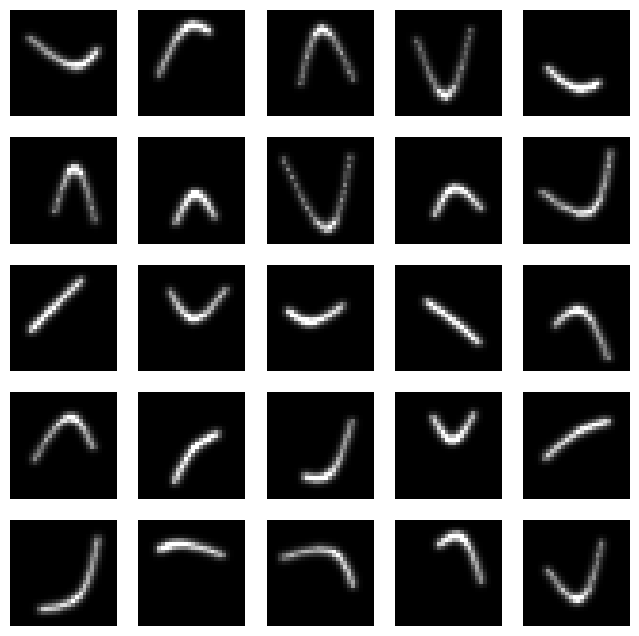

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(8,8))

for i, ax in enumerate(axs.flat):
    rand = np.random.randint(0,9999)
    ax.imshow(np.array(test_dataset[rand])[0].reshape(28,28), cmap='gray')
    ax.axis('off')

### Step 4: Create autoencoder model

Here we create our basic autoencoder, `model`. We then initialise different copies of the model, to be trained with different optimizers, for comparison.

The architecture of the autoencoder model is as follows:

| Code | Explanation |
| :- | :- |
| `nn.Linear(784, 1000, dtype=torch.float32)`             | Input layer: Takes in a flattened 28x28 pixel (784 values) image as input and outputs a 1000-dimensional vector |
| `nn.ReLU()`                                             | Activation function: Applies the ReLU (Rectified Linear Unit) function the output of the previous layer to introduce non-linearity |
|`nn.Linear(1000, 500, dtype=torch.float32)`            | Hidden layer: Takes the 1000-dimensional vector and outputs a 500-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(500, 250, dtype=torch.float32)`          |    Hidden layer: Takes the 500-dimensional vector and reduces the output down to a 250-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(250, 30, dtype=torch.float32)`            |   Waist layer: Takes the 250-dimensional vector and outputs a 30-dimensional vector. This is the smallest compressed representation of the data, every possible feature should be able to be described with no less than 30 degrees of freedom. |
| `nn.Linear(30, 250, dtype=torch.float32)`     |          Start of the decoder part of the network: Takes the 30-dimensional vector and upscales to a 250-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(250, 500, dtype=torch.float32)`       |       Hidden layer: Takes the 250-dimensional vector and upscales again to a 500-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(500, 1000, dtype=torch.float32)`     |        Hidden layer: Takes the 500-dimensional vector and outputs a 1000-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(1000, 784, dtype=torch.float32)`      |       Output layer: Takes the 1000-dimensional vector and outputs the 784-dimensional vector, which is the same size as the input. This is the reconstructed image. |

In [6]:
model = nn.Sequential(
    nn.Linear(784, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 30, dtype=torch.float32),
    nn.Linear(30, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 784, dtype=torch.float32),
)

### Initialising FishLeg optimizer

Here we prepare FishLeg for optimizing our autoencoder. To do so, we first need to modify our autoencoder model by calling `initialise_FishModel`. This replaces the layer objects in the above model with modified versions that contain additional parameters that are necessary for calculations performed by FishLeg. As with many optimizers, FishLeg has a selection of hyperparameters that can be tuned according to the problem at hand. FishLeg shares similar hyperparameters with other optimizers, however it has additional hyperparameters for the online, meta-learning that FishLeg performs.

In [ ]:
from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel

## Create FishLeg autoencoder model ##
model_FishLeg = copy.deepcopy(model).to(device) # Create a deep copy of our model for training with FishLeg

scale_factor = 1
damping = 0.1
model_FishLeg = initialise_FishModel(
    model_FishLeg, module_names="__ALL__", fish_scale=scale_factor / damping
)

model_FishLeg = model_FishLeg.to(device) # Select device to train our model on


## Setting FishLeg optimizer parameters ##
lr = 0.005
beta = 0.9
weight_decay = 1e-5
aux_lr = 1e-4
aux_eps = 1e-8
update_aux_every = 10
initialization = "normal"
normalization = True
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device) # Our selected function to evaluate the negative log-likelihood
writer = SummaryWriter(
    log_dir=f"runs/CURVES_fishleg/lr={lr}_auxlr={aux_lr}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

## Initialising FishLeg ##
opt = FishLeg(
    model_FishLeg,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
    aux_log=True,
    device=device
)

### Training with FishLeg:

Here we train our model using FishLeg using an arbitrary training loop. This training loop is identical to training with Adam.

In [ ]:
epochs = 100

st = time.time()
eval_time = 0

train_losses_FishLeg = [] # Saving our losses for comparison...
test_losses_FishLeg = []
auxiliary_losses = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_FishLeg(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()
            auxiliary_losses.append(opt.aux_loss)

            et = time.time()
            if n % 50 == 0:
                model_FishLeg.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_FishLeg(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_FishLeg.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_FishLeg.append(running_loss / n)
        test_losses_FishLeg.append(running_test_loss)

        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

print(f"training time: {(time.time() - st) / 60 :.2f} minutes")

Epoch 100: 100%|██████████| 200/200 [00:04<00:00, 44.10batch/s, loss=53, test_loss=60.7]

training time: 7.07 minutes


In [ ]:
%cd ..

/content


### Initialising Adam optimizer:

Here we prepare Adam for optimising our autoencoder. This step, similarly to the FishLeg initialisation, requires defining various hyperparameters for the Adam optimiser.

In [ ]:
## Create ADAM autoencoder model ##
model_ADAM = copy.deepcopy(model).to(device) # Create a deep copy of our model for training with ADAM

## Setting ADAM optimizer parameters ##
lr = 0.005
weight_decay = 1e-5
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

## Initialising ADAM ##
opt = optim.Adam(
    model_ADAM.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

writer = SummaryWriter(
    log_dir=f"runs/CURVES_adam/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

### Training with Adam:

This training loop is identical to training with FishLeg, except Adam does not utilise an auxiliary loss, so we do not track that here.

In [ ]:
epochs = 100

st = time.time()
eval_time = 0

train_losses_ADAM = [] # Saving our losses for comparison...
test_losses_ADAM = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_ADAM(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model_ADAM.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_ADAM(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_ADAM.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_ADAM.append(running_loss / n)
        test_losses_ADAM.append(running_test_loss)

        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

print(f"training time: {(time.time() - st) / 60 :.2f} minutes")

Epoch 100: 100%|██████████| 200/200 [00:02<00:00, 83.47batch/s, loss=55.2, test_loss=62.3] 

training time: 4.76 minutes


#### Plots

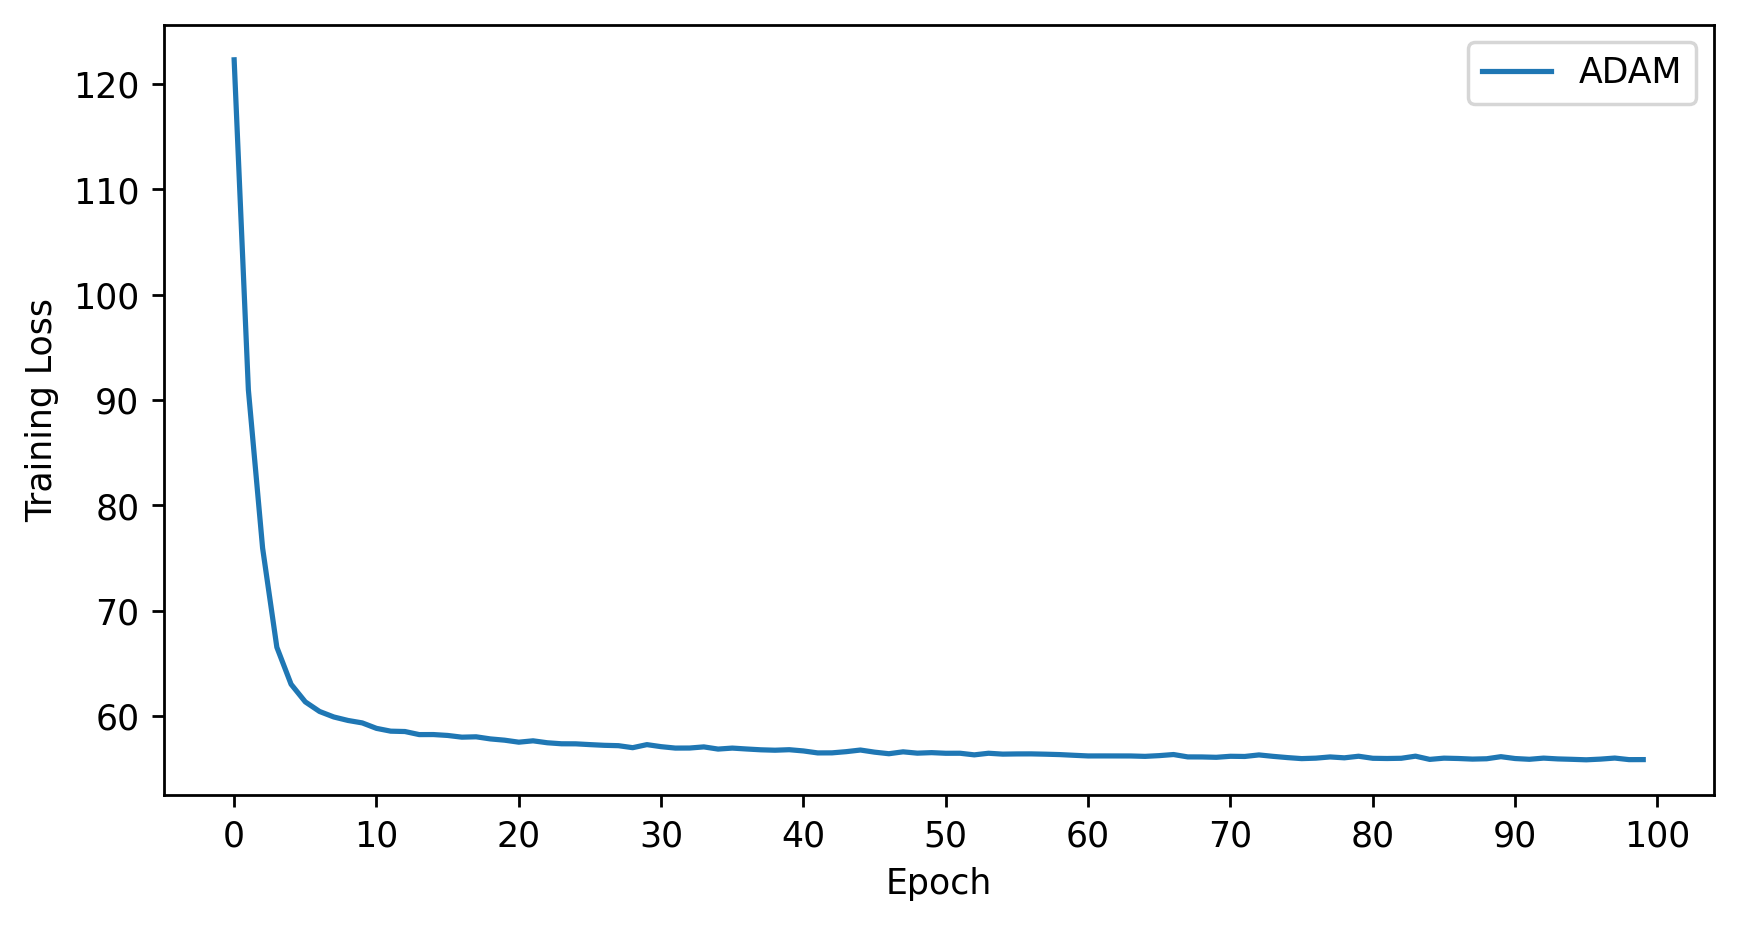

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(train_losses_ADAM, 'tab:blue',label="ADAM")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/adam_trainingLoss.png', bbox_inches='tight')

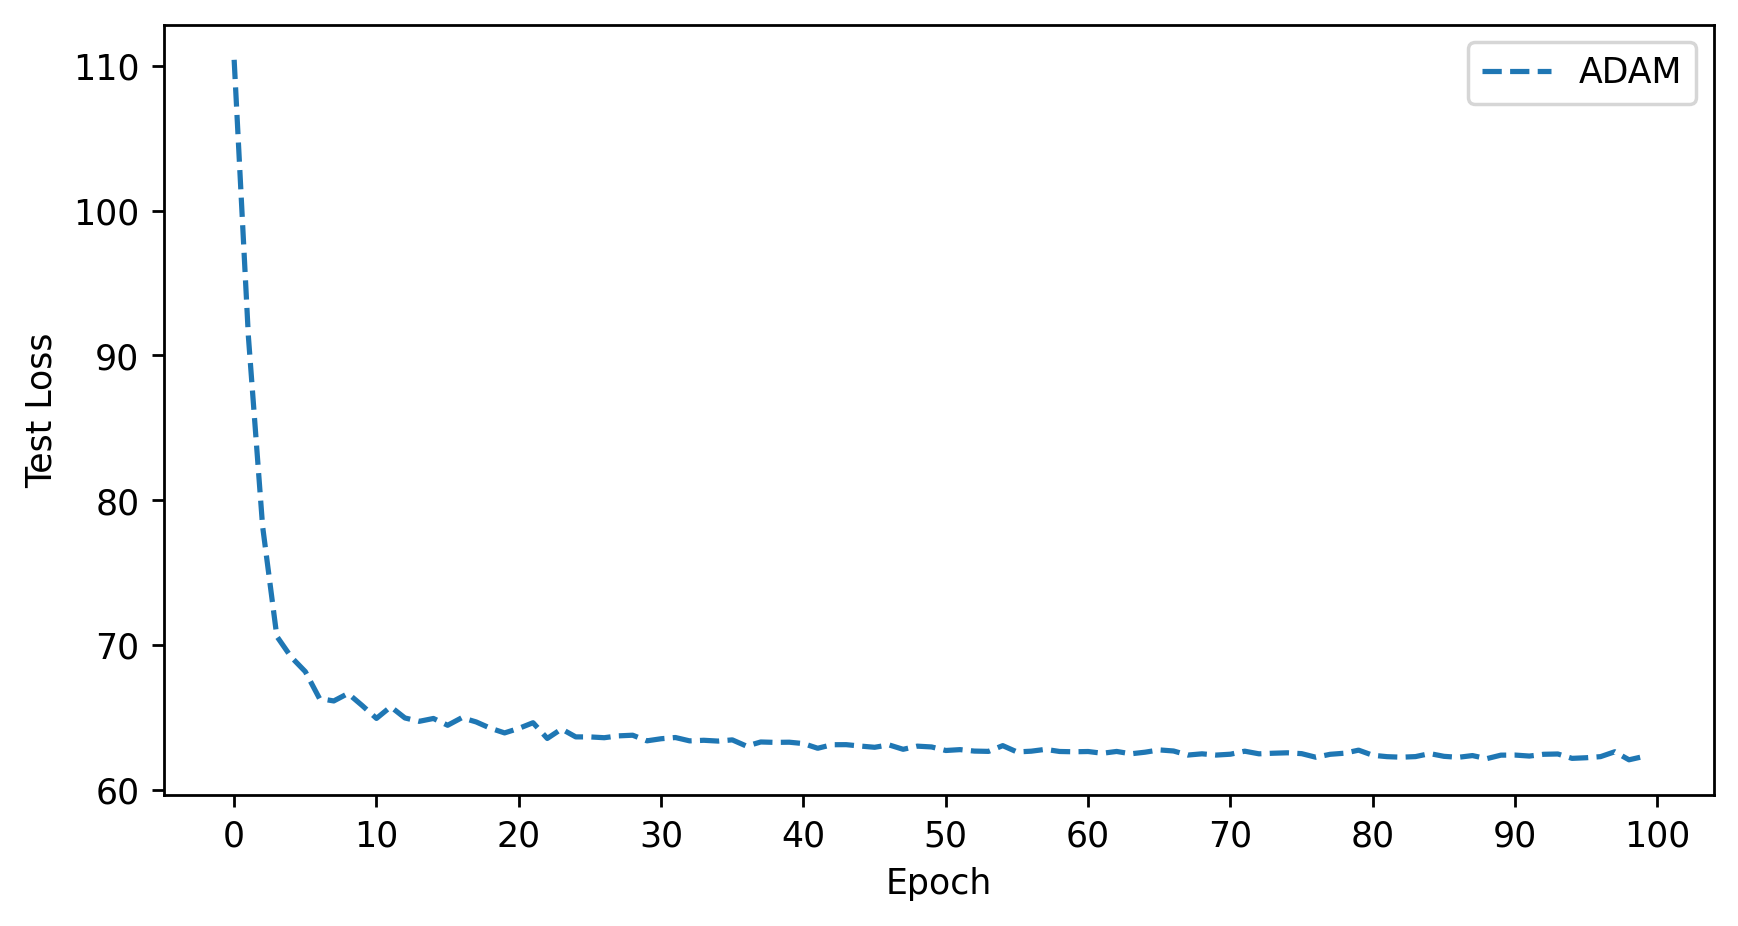

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(test_losses_ADAM, 'tab:blue',label="ADAM", linestyle="dashed")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Test Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/adam_testLoss.png', bbox_inches='tight')

### FishLeg versus Adam:

Now we will look at how the loss improves over the training period for FishLeg and Adam. In the plot below, we can see that after training for 100 epochs, FishLeg converges to a lower training loss than Adam. In this case, the training time of FishLeg was a few minutes longer, but it took just 5 epochs for FishLeg to reach a lower loss than Adam converges to in 100 epochs.

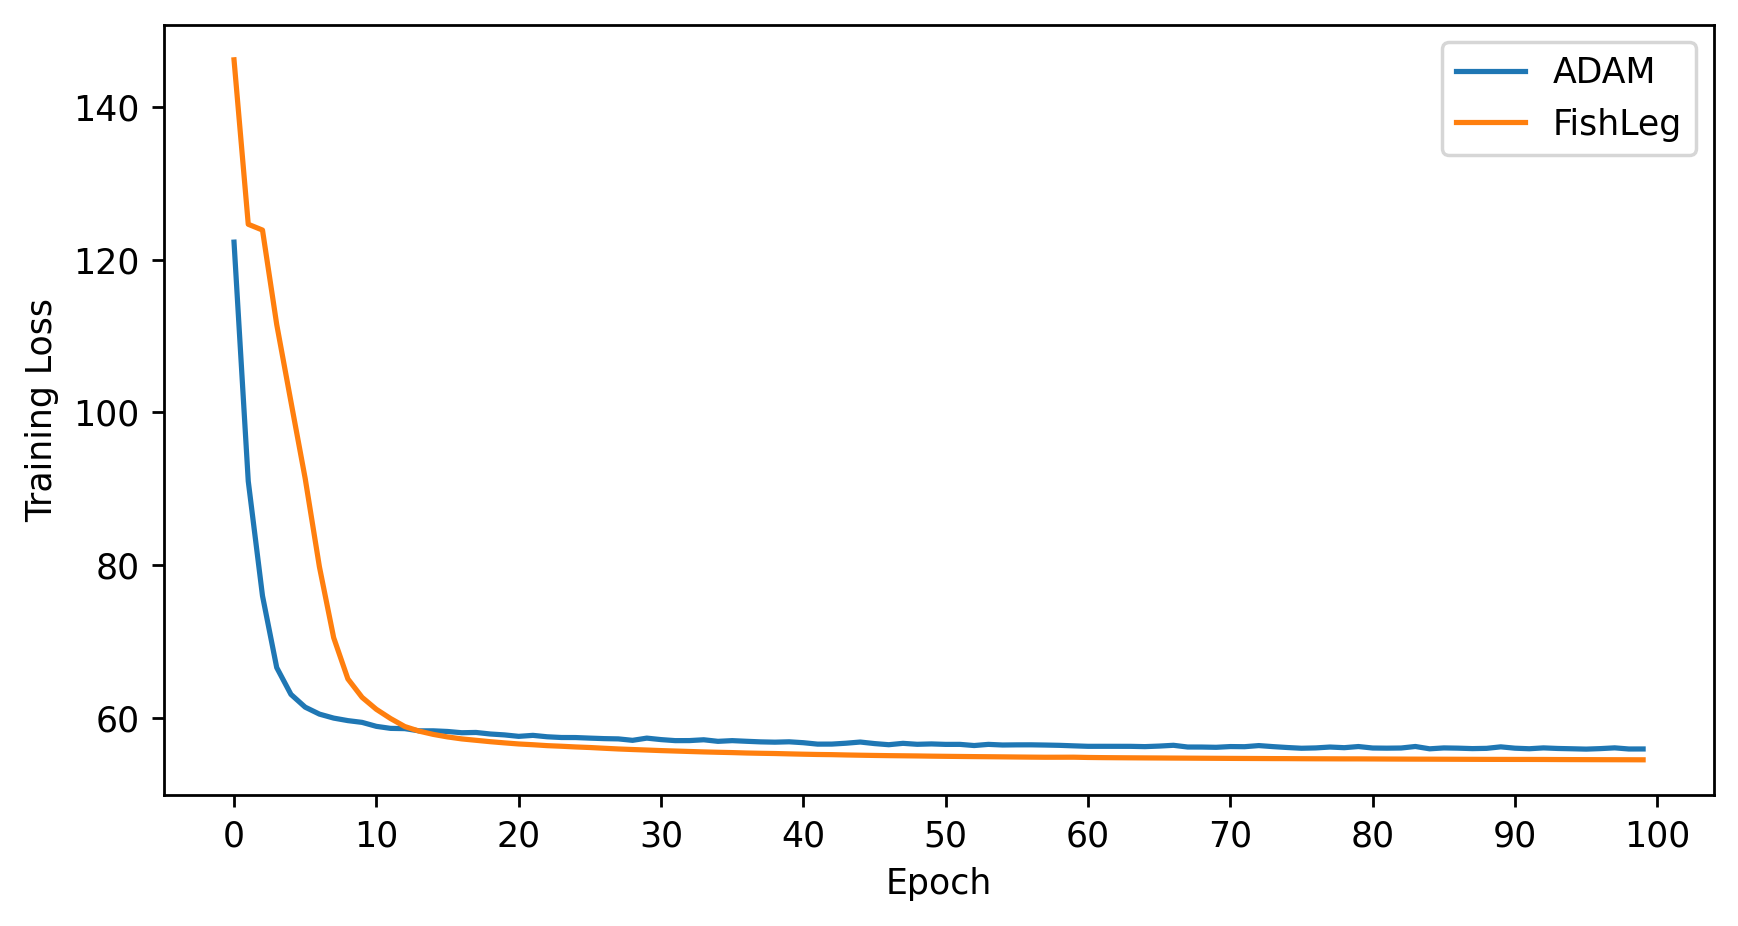

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(train_losses_ADAM, 'tab:blue',label="ADAM")
plt.plot(train_losses_FishLeg, 'tab:orange',label="FishLeg")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/fishleg_vs_adam_trainingLoss.png')

In the plot below, we see a similar trend for the test loss. This indicates that the FishLeg model is generalising well to unseen test data. Furthermore, the test loss is more stable for the FishLeg model.

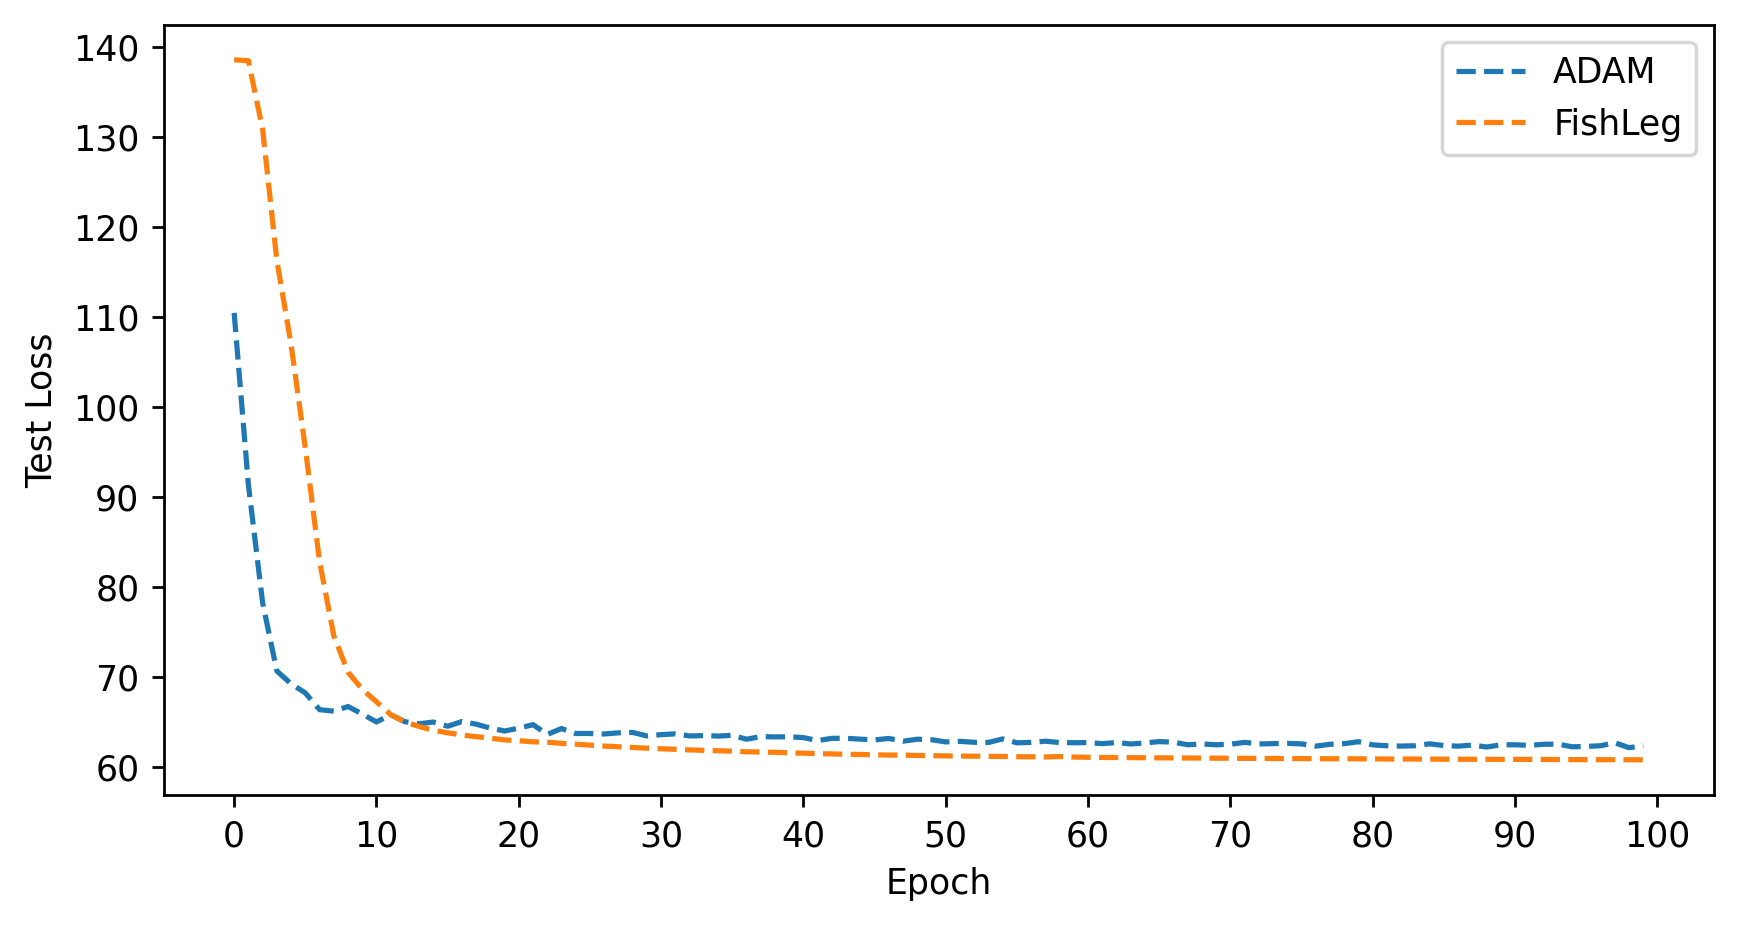

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(test_losses_ADAM, 'tab:blue',label="ADAM", linestyle="dashed")
plt.plot(test_losses_FishLeg, 'tab:orange',label="FishLeg", linestyle="dashed")
plt.xticks(np.arange(0, 101, 10))

plt.xlabel("Epoch")
plt.ylabel("Test Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/fishleg_vs_adam_testLoss.png')

Is FishLeg better approximating the Fisher matrix over the training period? We can see below that as our auxiliary loss improves over time, showing that the approximation for the Fisher is improving as our training iterates. Plotting the test loss alongside the auxiliary loss, we can see that the test loss improves in accordance with the improvements in auxiliary loss. However, the auxiliary loss is far more noisy.

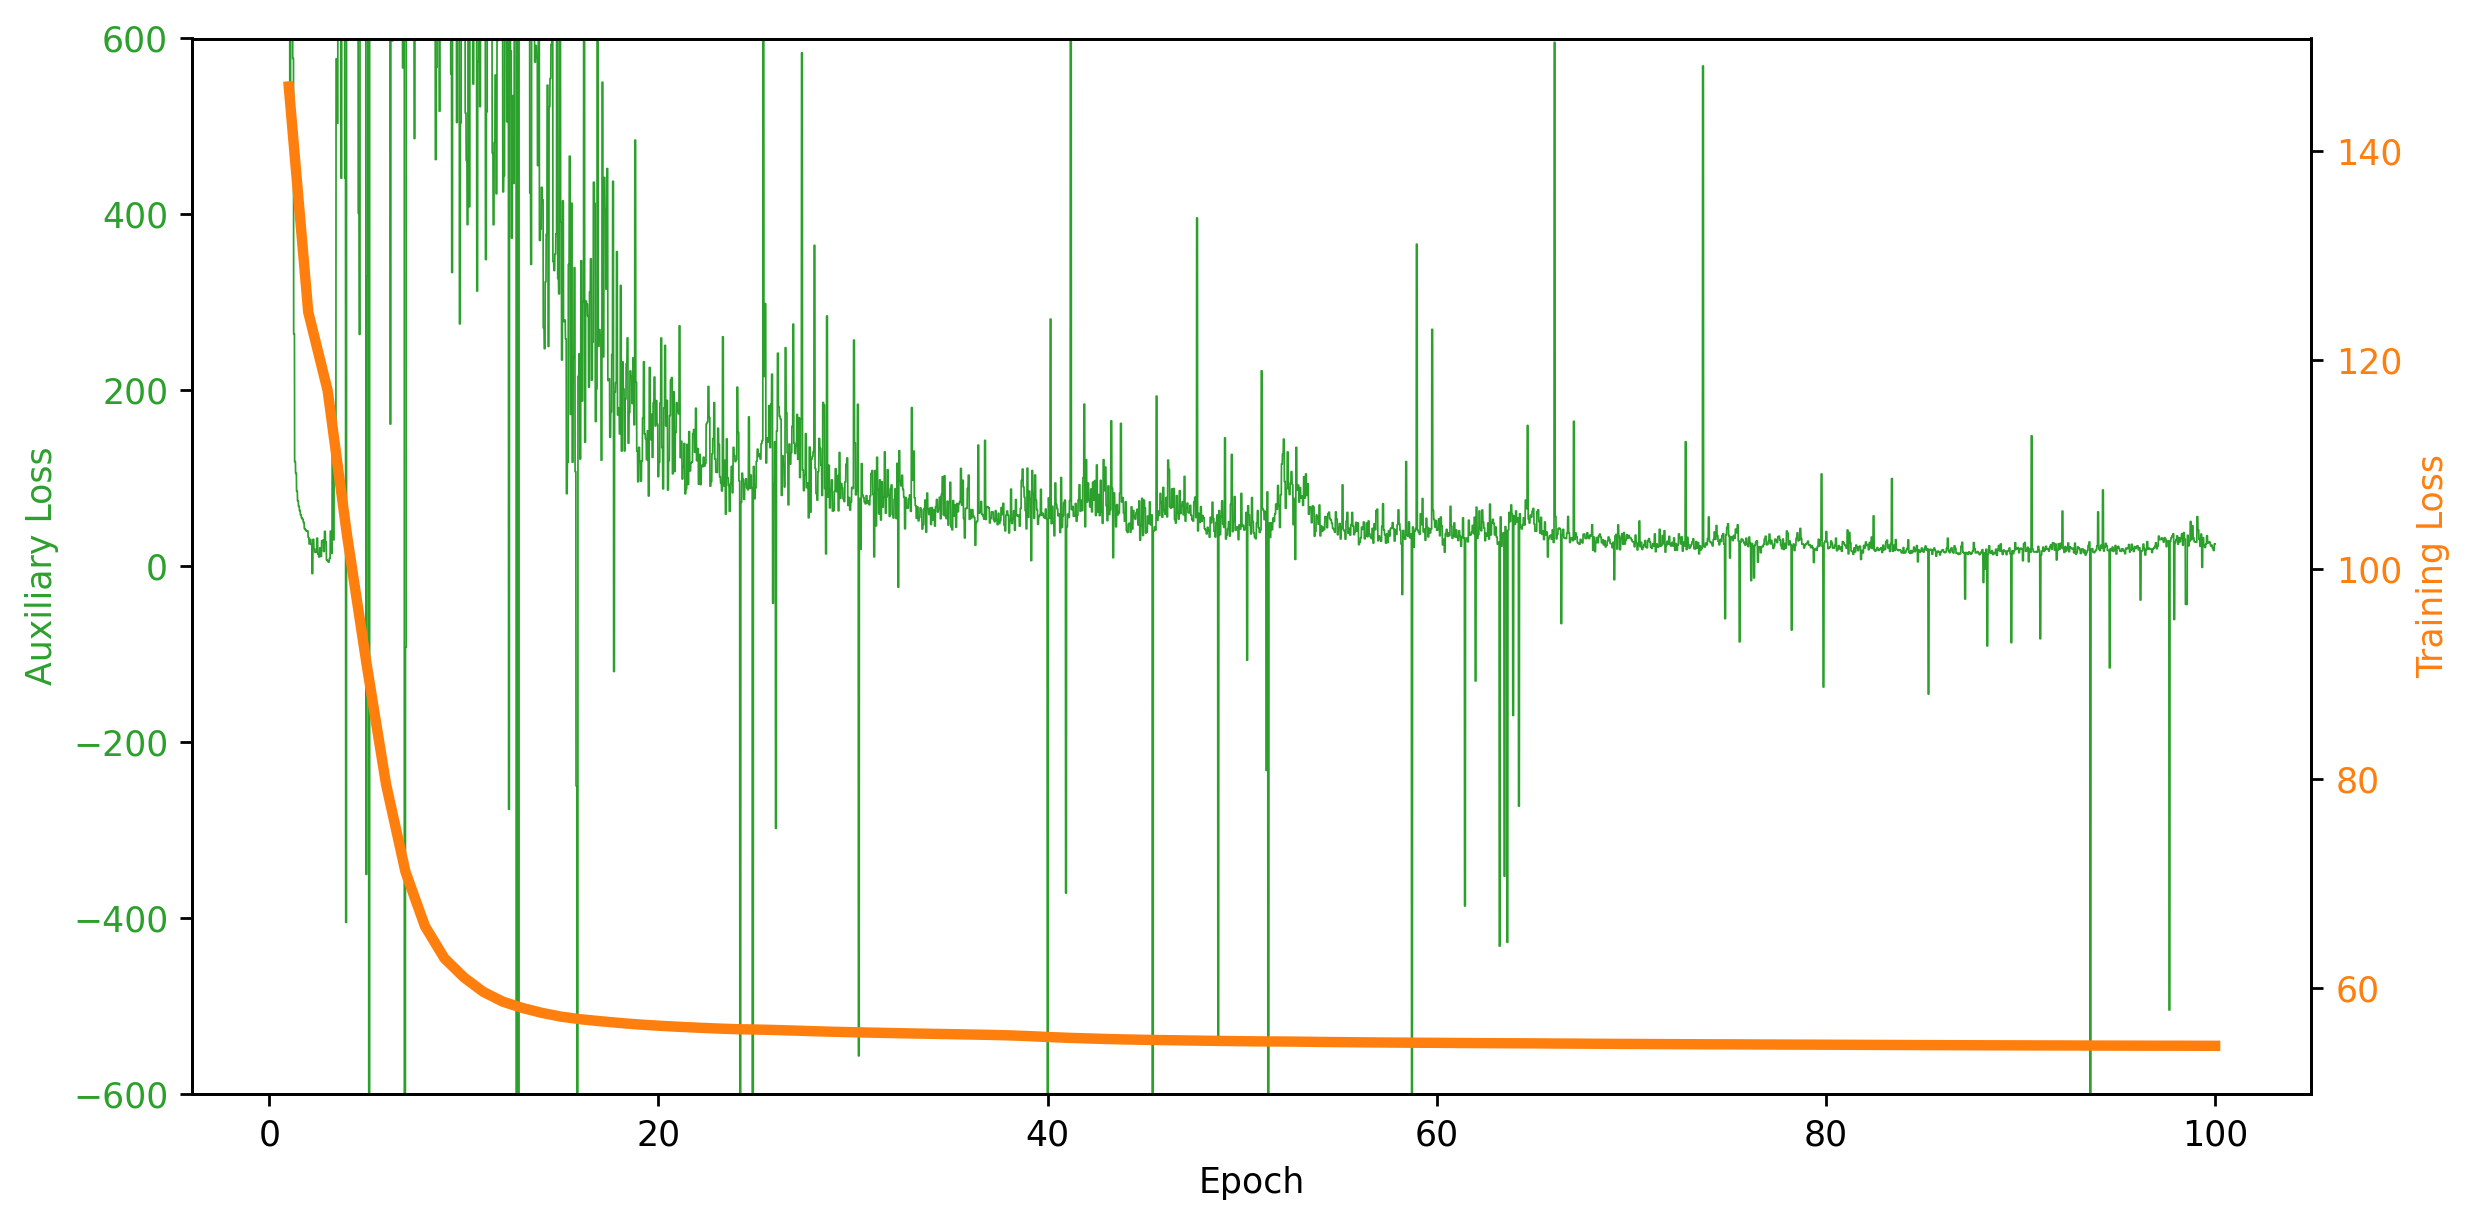

In [ ]:
auxiliary_losses = [i.to("cpu") for i in auxiliary_losses if i]
x1 = np.linspace(1,100,19990)
x2 = np.linspace(1,100,100)

fig, ax1 = plt.subplots(figsize=(10, 5), dpi = 250)

color = 'tab:green'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Auxiliary Loss', color=color)
ax1.plot(x1, auxiliary_losses, color=color, linewidth=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((-600,600))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Training Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, train_losses_FishLeg, color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

What does this mean for the reconstructed images? Lets compare the reconstructions produced by FishLeg against those produced by Adam. Below we have plotted three random images from the test set along with their FishLeg and Adam reconstructions. For each reconstruction, the mean squared error (MSE) has been calculated (lower is better, with the best being zero), along with a second plot below that illustrates the sources of errors. The closer these second plots are to the light-colored test plot (i.e. zero squared error everywhere), the closer the reconstructed image is to the true image.

Run this cell multiple times to observe results for different random images.

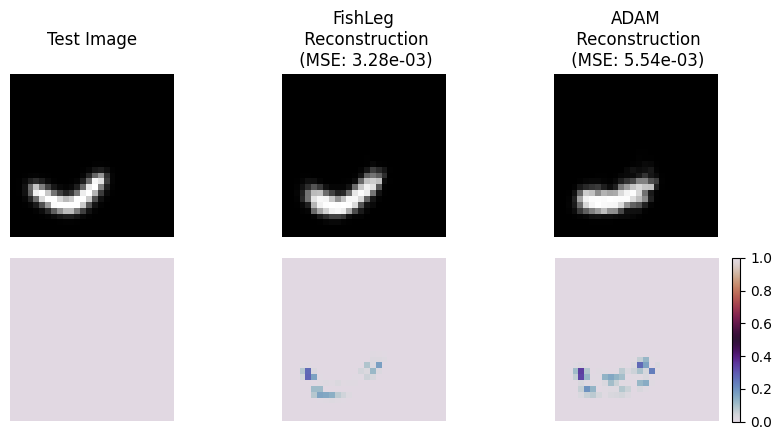

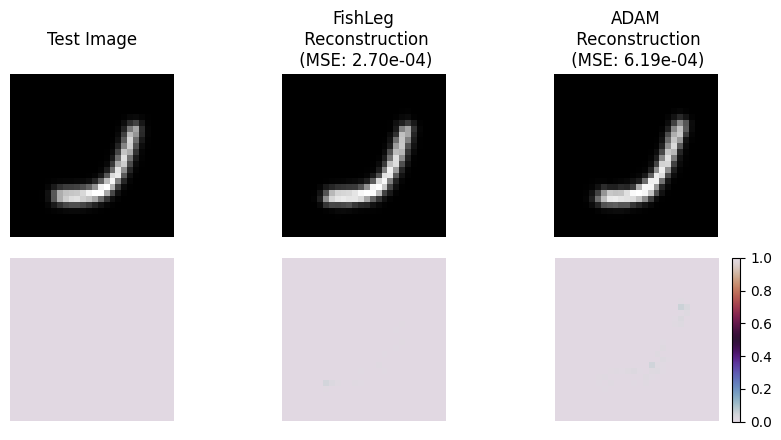

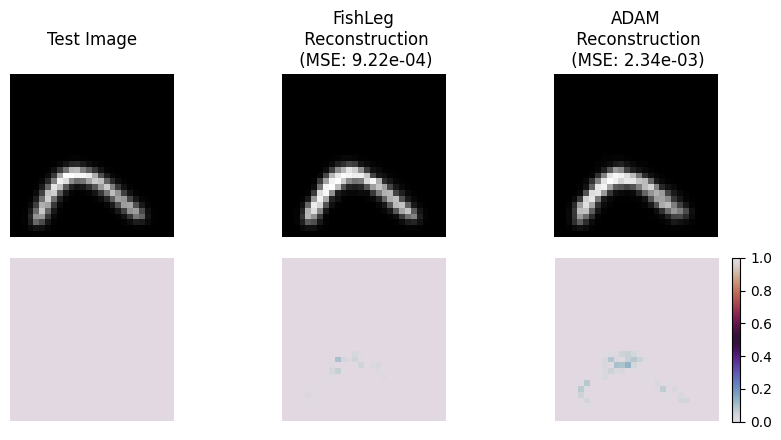

In [ ]:
mse = nn.MSELoss() # PyTorch implementation of mean squared error


for i in range(3):

    i=np.random.randint(0,9999)
    cmap1 = 'Greys_r'
    cmap2 = 'twilight'

    test_image = test_dataset[i][0]
    test_image_numpy = np.array(test_image)
    fishleg_reconstruction = torch.sigmoid(model_FishLeg(test_image.to(device))).cpu().detach()
    adam_reconstruction = torch.sigmoid(model_ADAM(test_image.to(device))).cpu().detach()

    fig, axs = plt.subplots(2,3, figsize=(8.6,4.5))
    axs=axs.flatten()

    axs[0].imshow(test_image_numpy.reshape(28,28), cmap=cmap1)
    axs[0].axis('off')
    axs[0].set_title(f"Test Image\n")

    axs[1].imshow(np.array(fishleg_reconstruction).reshape(28,28), cmap=cmap1)
    axs[1].axis('off')
    mse_fishleg = mse(fishleg_reconstruction,test_image)
    axs[1].set_title("FishLeg\n Reconstruction\n (MSE: {:.2e})".format(mse_fishleg))

    axs[2].imshow(np.array(adam_reconstruction).reshape(28,28), cmap=cmap1)
    axs[2].axis('off')
    mse_adam = mse(adam_reconstruction,test_image)
    axs[2].set_title("ADAM\n Reconstruction\n (MSE: {:.2e})".format(mse_adam))

    err = lambda x: (x-test_image_numpy)**2 # Calculate squared error

    axs[3].imshow(err(test_image_numpy).reshape(28,28), cmap=cmap2, vmin=0, vmax=1)
    axs[3].axis('off')

    axs[4].imshow(err(fishleg_reconstruction).reshape(28,28), cmap=cmap2, vmin=0, vmax=1)
    axs[4].axis('off')

    im = axs[5].imshow(err(adam_reconstruction).reshape(28,28), cmap=cmap2, vmin=0, vmax=1)
    axs[5].axis('off')

    fig.colorbar(im, ax=axs[5])


    plt.tight_layout()

### Initialising RMSprop optimizer:

Here we prepare RMSprop for optimising our autoencoder. This step, similarly to the FishLeg initialisation, requires defining various hyperparameters for the RMSprop optimiser.

In [ ]:
## Create RMSprop autoencoder model ##
model_RMSprop = copy.deepcopy(model).to(device) # Create a deep copy of our model for training with ADAM

## Setting RMSprop optimizer parameters ##
lr = 1e-2
eps = 1e-4
weight_decay = 1e-5
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

## Initialising RMSprop ##
opt = optim.RMSprop(
    model_RMSprop.parameters(),
    lr=lr,
    eps=eps,
    weight_decay=weight_decay,
)

writer = SummaryWriter(
    log_dir=f"runs/CURVES_rmsprop/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

### Training with RMSprop:

This training loop is identical to training with FishLeg, except RMSprop does not utilise an auxiliary loss, so we do not track that here.

In [ ]:
epochs = 100

st = time.time()
eval_time = 0

train_losses_RMSprop = [] # Saving our losses for comparison...
test_losses_RMSprop = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_RMSprop(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model_RMSprop.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_RMSprop(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_RMSprop.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_RMSprop.append(running_loss / n)
        test_losses_RMSprop.append(running_test_loss)

        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

print(f"training time: {(time.time() - st) / 60 :.2f} minutes")

Epoch 100: 100%|██████████| 200/200 [00:02<00:00, 87.59batch/s, loss=65.7, test_loss=74] 

training time: 4.21 minutes


#### Plots

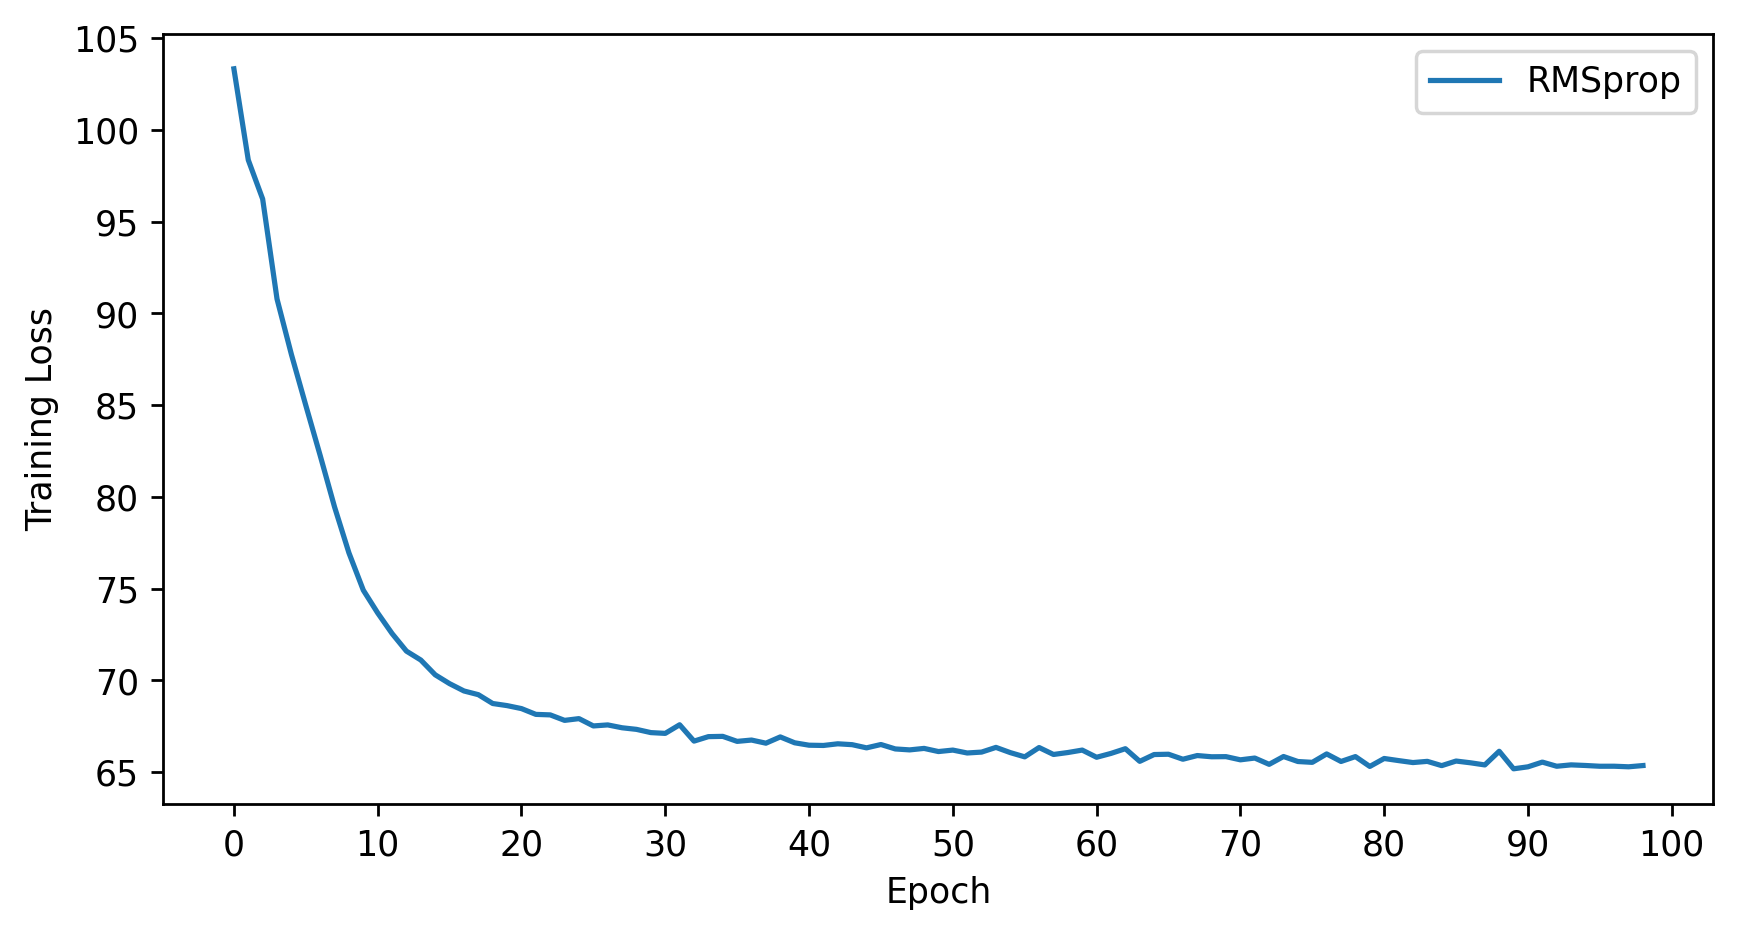

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(train_losses_RMSprop[1:], 'tab:blue',label="RMSprop")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/rmsprop_trainingLoss.png', bbox_inches='tight')

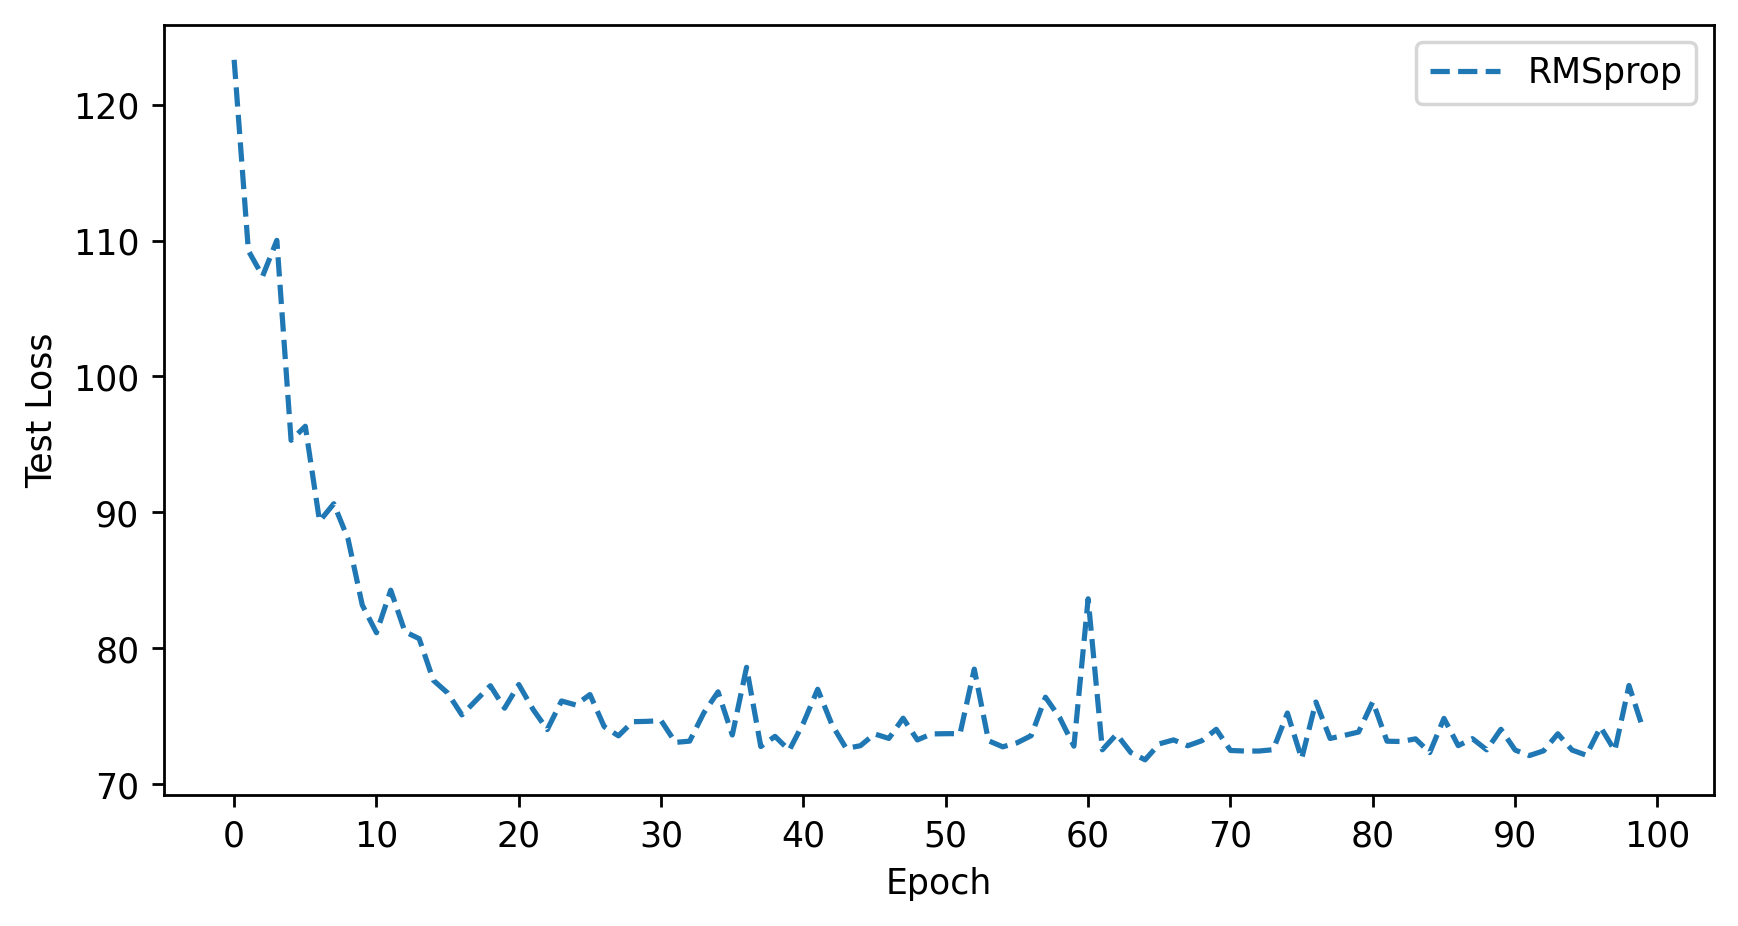

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(test_losses_RMSprop, 'tab:blue',label="RMSprop", linestyle="dashed")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Test Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/rmsprop_testLoss.png', bbox_inches='tight')

### Initialising SGD-m optimizer:

Here we prepare SGD-m for optimising our autoencoder. This step, similarly to the FishLeg initialisation, requires defining various hyperparameters for the SGD-m optimiser.

In [ ]:
## Create RMSprop autoencoder model ##
model_SGD_m = copy.deepcopy(model).to(device) # Create a deep copy of our model for training with ADAM

## Setting RMSprop optimizer parameters ##
lr = 1e-2
momentum = 0
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

## Initialising RMSprop ##
opt = optim.SGD(
    model_SGD_m.parameters(),
    lr=lr,
    momentum=momentum
)

writer = SummaryWriter(
    log_dir=f"runs/CURVES_sgd_m/lr={lr}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

### Training with SGD-m:

This training loop is identical to training with FishLeg, except SGD-m does not utilise an auxiliary loss, so we do not track that here.

In [ ]:
epochs = 100

st = time.time()
eval_time = 0

train_losses_SGD_m  = [] # Saving our losses for comparison...
test_losses_SGD_m  = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_SGD_m(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model_SGD_m.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_SGD_m(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_SGD_m.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_SGD_m.append(running_loss / n)
        test_losses_SGD_m.append(running_test_loss)

        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

print(f"training time: {(time.time() - st) / 60 :.2f} minutes")

Epoch 100: 100%|██████████| 200/200 [00:02<00:00, 85.29batch/s, loss=57.4, test_loss=62.7] 

training time: 4.17 minutes


#### Plots

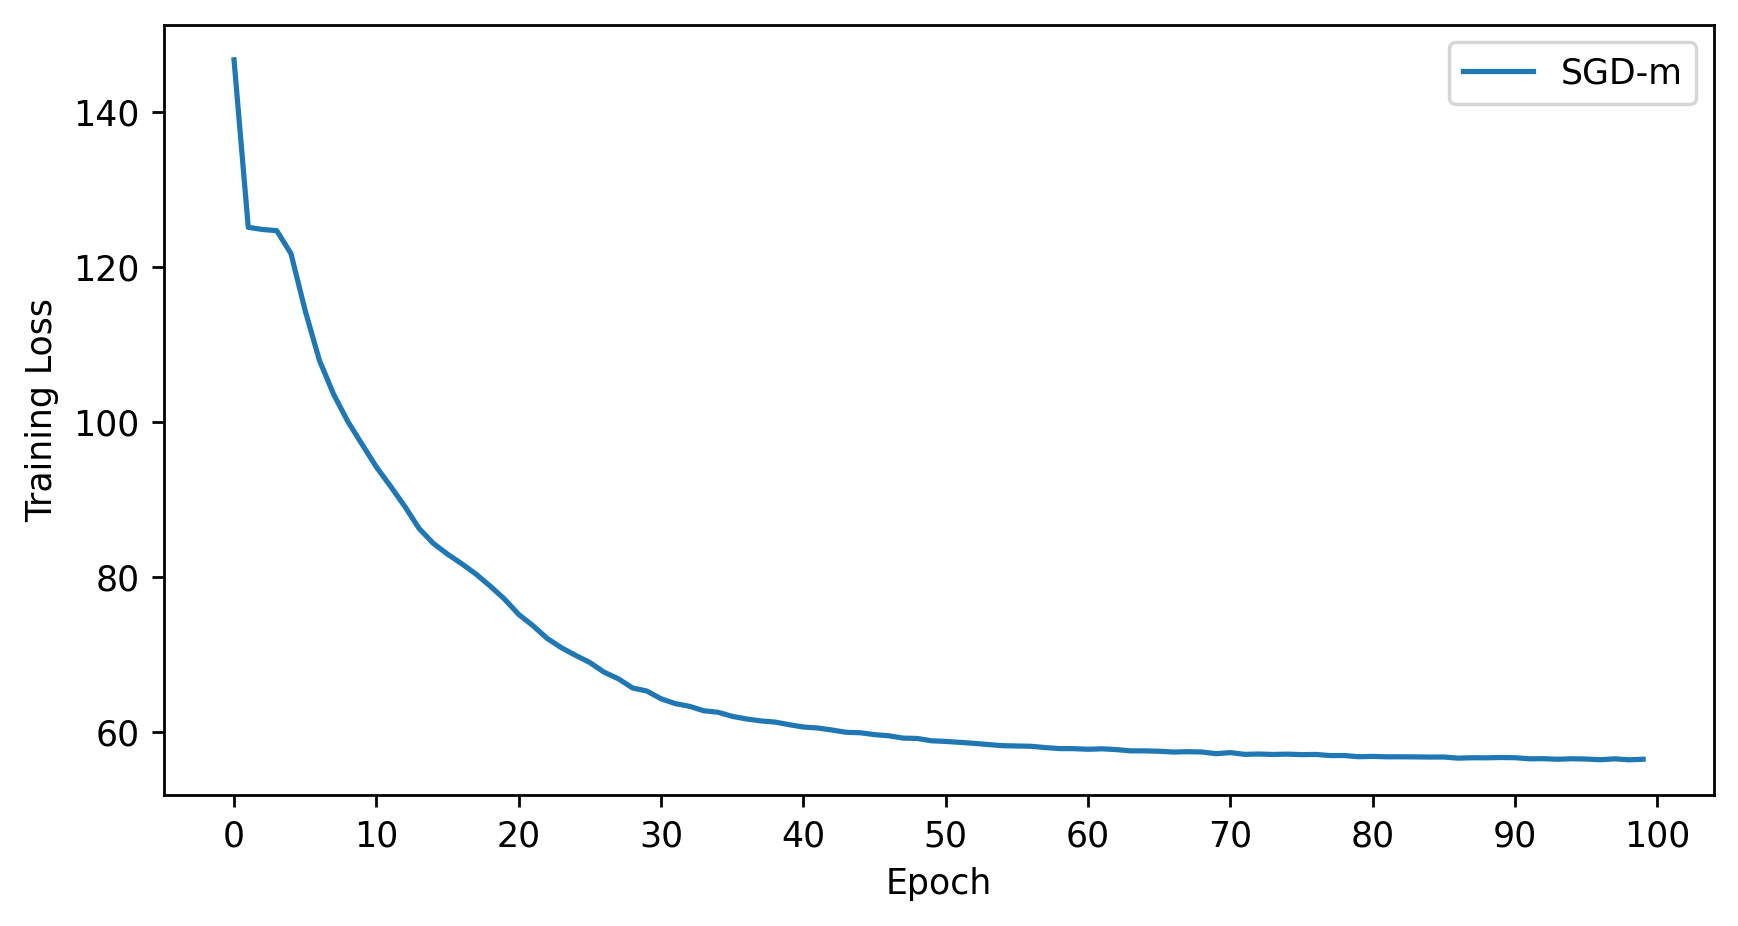

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(train_losses_SGD_m, 'tab:blue',label="SGD-m")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/sgd-m_trainingLoss.png', bbox_inches='tight')

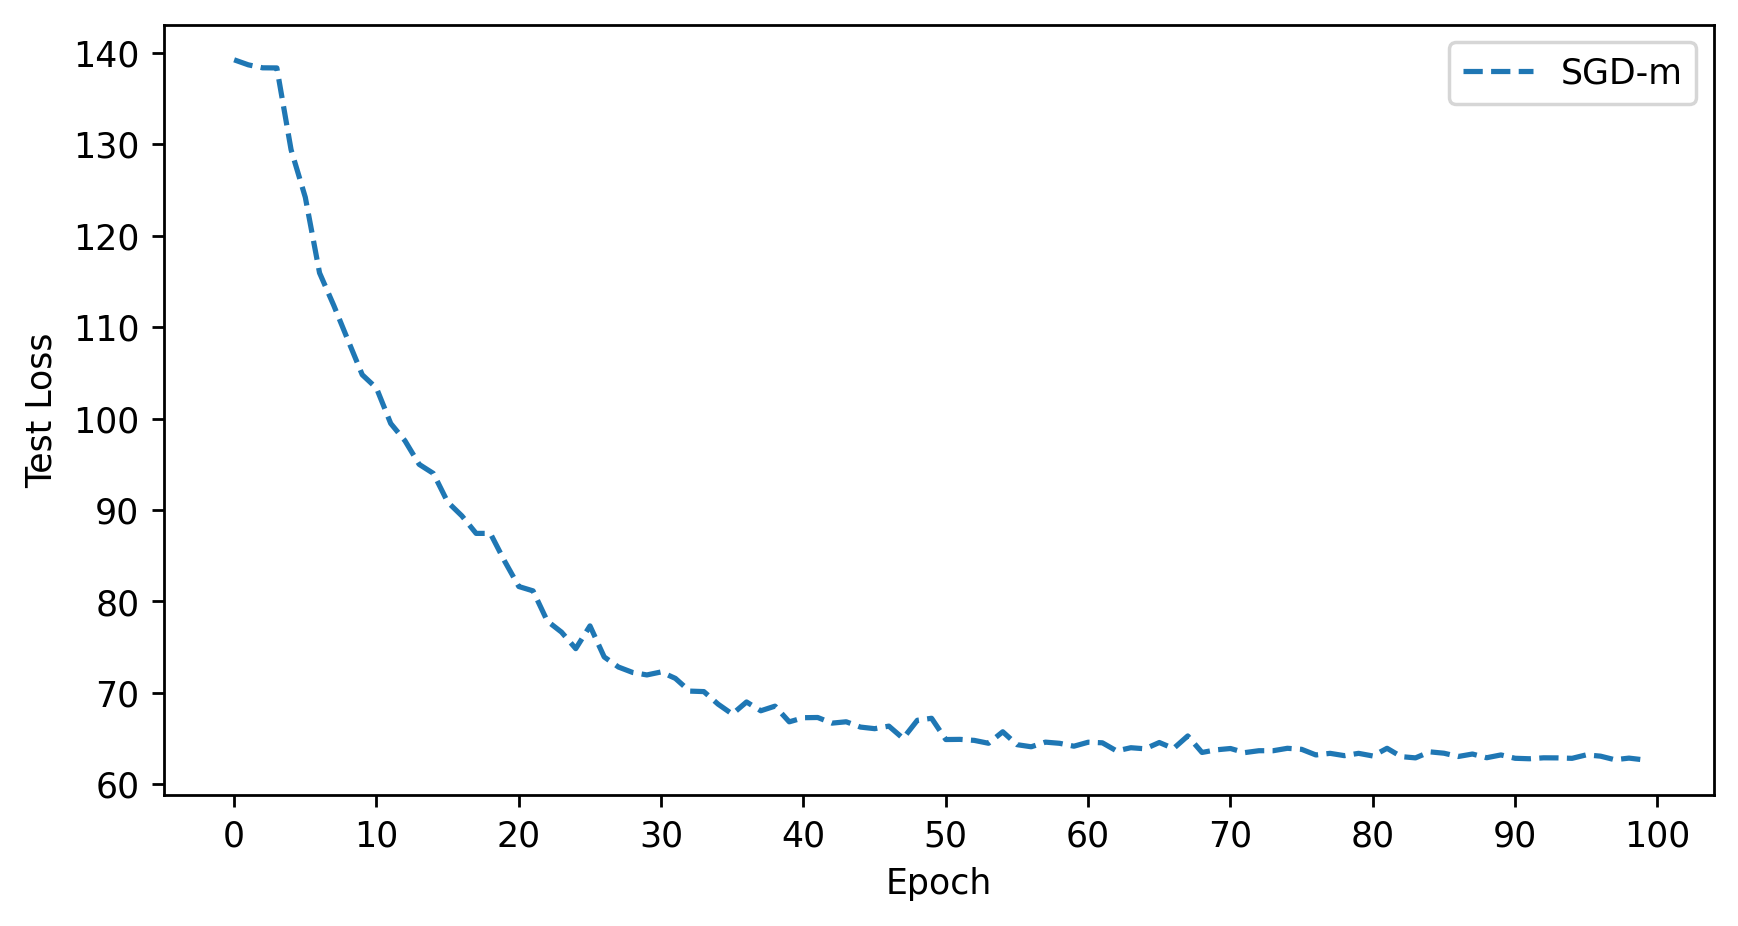

In [ ]:
plt.figure(figsize=(8, 4), dpi = 250)

plt.plot(test_losses_SGD_m, 'tab:blue',label="SGD-m", linestyle="dashed")
plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Test Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/sgd-m_testLoss.png', bbox_inches='tight')

### Comparison between FishLeg and other optimizers

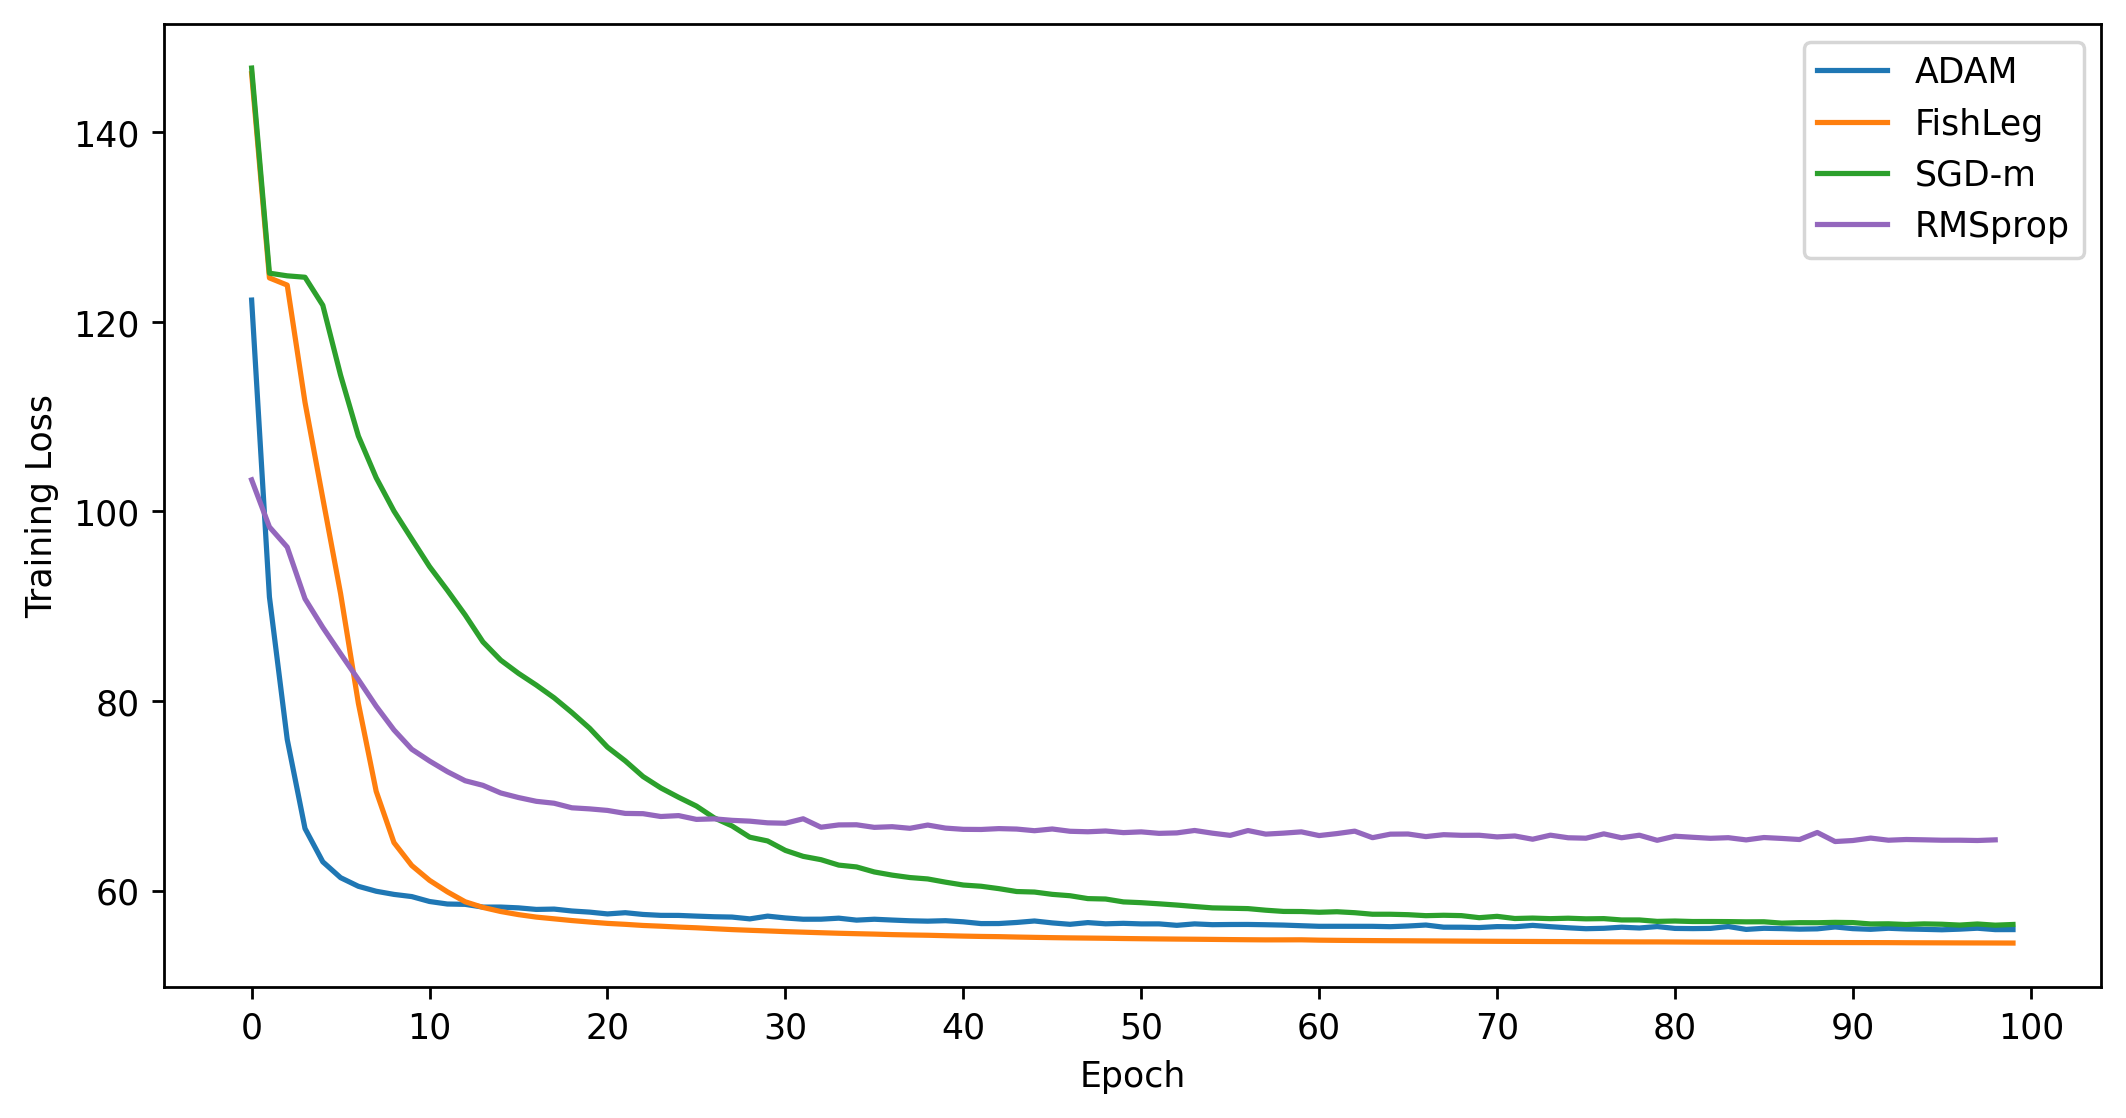

In [ ]:
plt.figure(figsize=(10, 5), dpi = 250)

plt.plot(train_losses_ADAM, 'tab:blue',label="ADAM")
plt.plot(train_losses_FishLeg, 'tab:orange',label="FishLeg")
plt.plot(train_losses_SGD_m, 'tab:green',label="SGD-m")
plt.plot(train_losses_RMSprop[1:], 'tab:purple',label="RMSprop")

plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/fishleg_vs_all_trainingLoss.png')

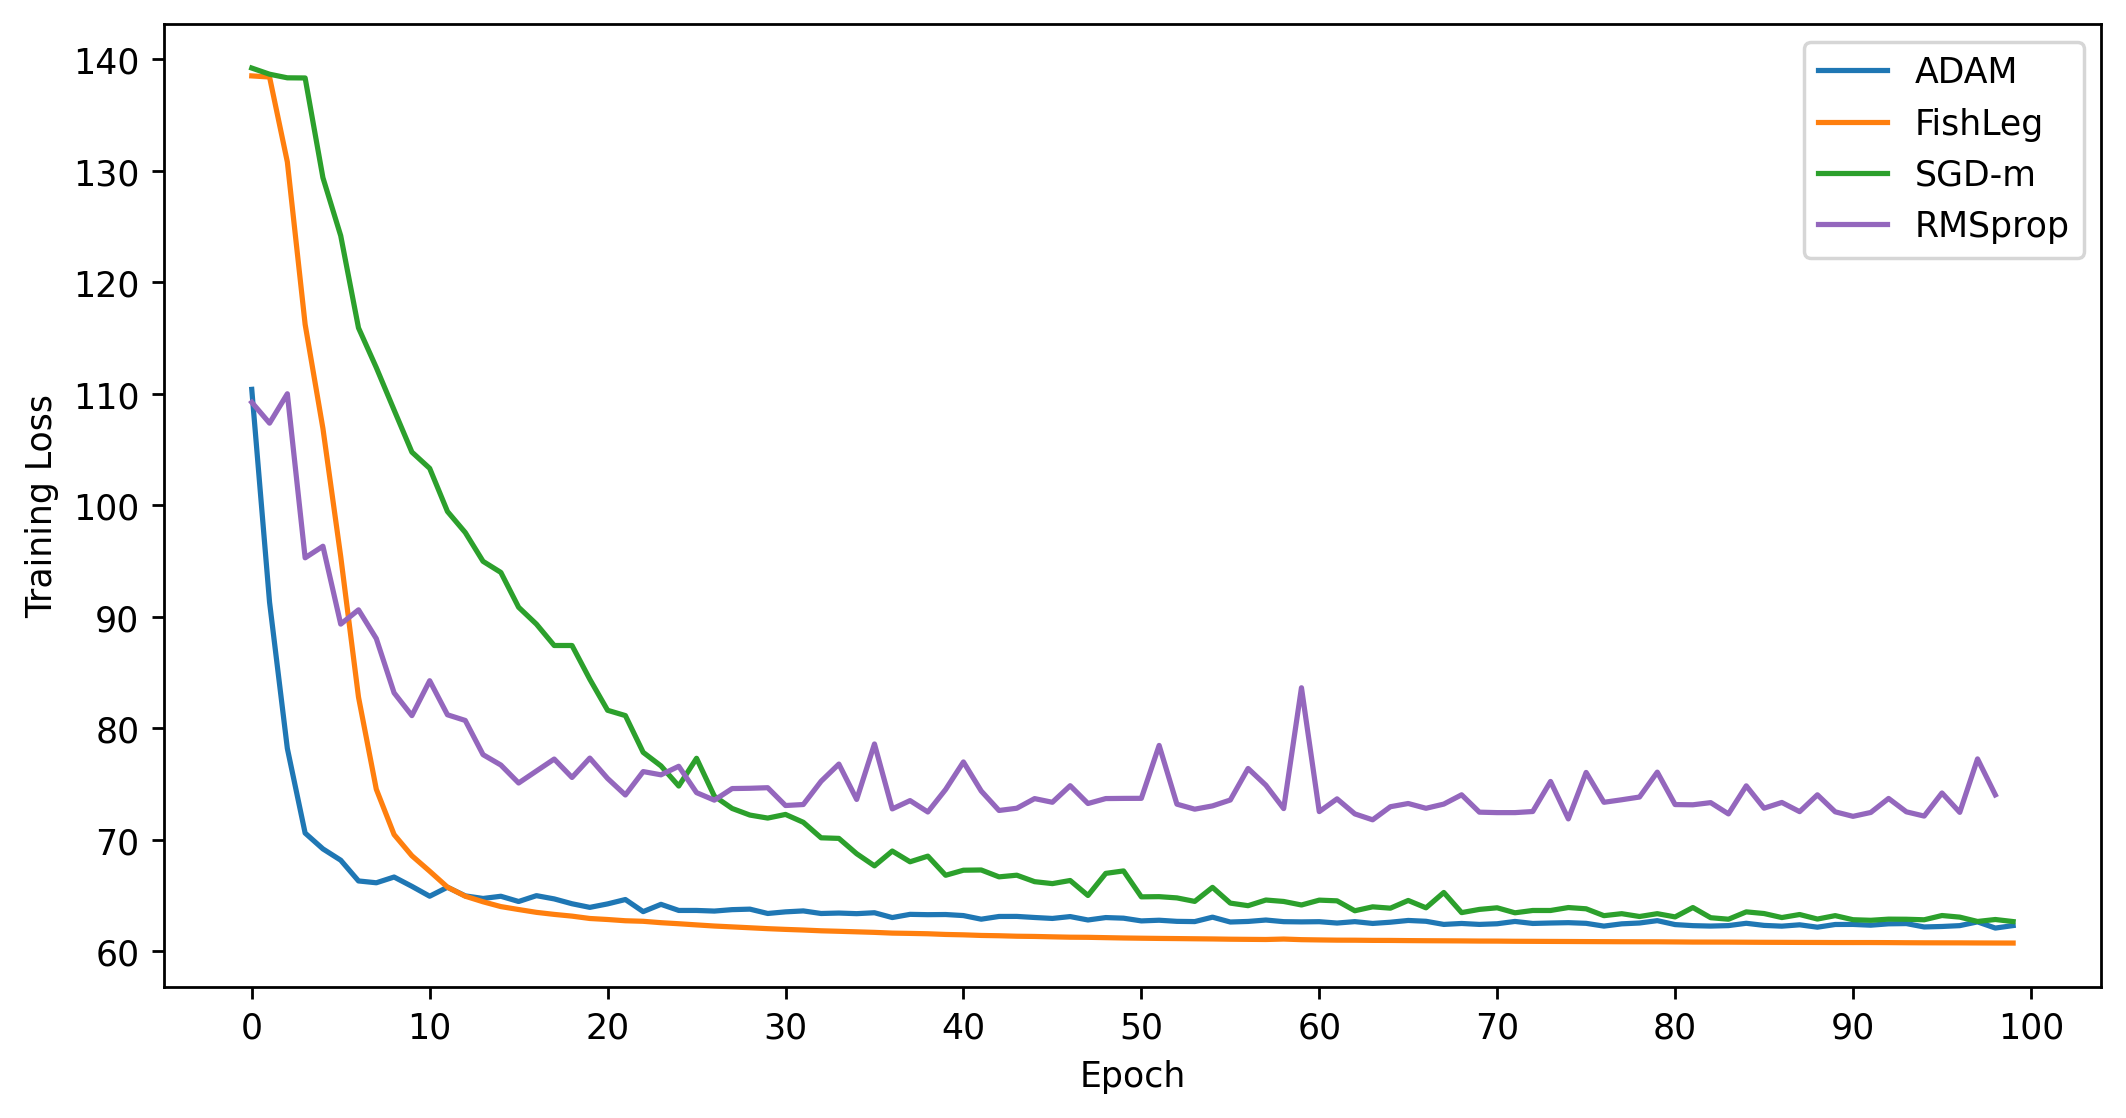

In [ ]:
plt.figure(figsize=(10, 5), dpi = 250)

plt.plot(test_losses_ADAM, 'tab:blue',label="ADAM")
plt.plot(test_losses_FishLeg, 'tab:orange',label="FishLeg")
plt.plot(test_losses_SGD_m, 'tab:green',label="SGD-m")
plt.plot(test_losses_RMSprop[1:], 'tab:purple',label="RMSprop")

plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(20, 180, 20))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.legend()
# plt.show()

plt.savefig('/content/figures/fishleg_vs_all_testLoss.png')